In [44]:
import matplotlib.pyplot as plt
from math import sin, cos, pi
from numpy import linspace, zeros

In [45]:
def tk(k, tau):
    return k * tau

def xi(l, i, h):
    return l + i * h

In [46]:
def phi0(t):
    return 0

def phi1(t):
    return 0

def psi1(x):
    return sin(x) + cos(x)

def ddpsi1(x):
    return -sin(x) - cos(x)

def psi2(x):
    return -(sin(x) + cos(x))

In [47]:
def analytic(t, x):
    return sin(x - t) + cos(x + t)

In [48]:
def explicit(N, K, l, r, t, coeffs, approx1=1, approx2=1):
    u = [[0.0 for _ in range(N + 1)] for _ in range(K + 1)]
    tau = t / K
    h = (r - l) / N
    sigma = (tau * tau) / (h * h)
    if sigma > 0.5:
        raise Exception("Stability exception")
    for i in range(N + 1):
        u[0][i] = psi1(xi(l, i, h))
        if approx1 == 1:
            u[1][i] = u[0][i] + psi2(xi(l, i, h)) * tau
        if approx1 == 2:
            u[1][i] = u[0][i] + psi2(xi(l, i, h)) * tau + ddpsi1(xi(l, i, h)) * (tau ** 2) / 2
    alpha, beta, gamma, delta = coeffs
    for k in range(2, K + 1):
        for i in range(1, N):
            u[k][i] = u[k - 1][i + 1] * sigma + u[k - 1][i] * (-2 * sigma + 2) + u[k - 1][i - 1] * sigma - u[k - 2][i]
        if approx2 == 1:    # двухточечная 1 порядка
            u[k][0] = -(alpha / h) / (beta - alpha / h) * u[k][1] + phi0(tk(k, tau)) / (beta - alpha / h)
            u[k][N] = (gamma / h) / (delta + gamma / h) * u[k][N - 1] + phi1(tk(k, tau)) / (delta + gamma / h)
        if approx2 == 2:    # трёхточечная 2 порядка
            u[k][0] = (2 * h * phi0(tk(k, tau)) - 4 * alpha * u[k][1] + alpha * u[k][2]) / (2 * beta * h - 3 * alpha)
            u[k][N] = (2 * h * phi1(tk(k, tau)) - gamma * u[k][N - 2] + 4 * gamma * u[k][N - 1]) / (2 * h * delta + 3 * gamma)
        if approx2 == 3:    # двухточечная 2 порядка
            b0 = 2 / h + h / tau - beta / alpha * 2
            c0 = -2 / h
            bN = 2 / h + h / tau + delta / gamma * 2
            aN = -2 / h
            d0 = h / tau * u[k - 1][0] - phi0(tk(k, tau)) * 2 / alpha
            dN = h/tau * u[k - 1][N] + phi1(tk(k, tau)) * 2 / gamma
            u[k][0] = (d0 - c0 * u[k][1]) / b0
            u[k][N] = (dN - aN * u[k][N - 1]) / bN
    return u

In [49]:
def TMA(A, B):
    n = len(A)
    a = [0] + [A[i][i - 1] for i in range(1, n)]
    b = [A[i][i] for i in range(n)]
    c = [A[i][i + 1] for i in range(n - 1)] + [0]
    d = [B[i][0] for i in range(n)]
    P = [0 for _ in range(n)]
    Q = [0 for _ in range(n)]
    P[0] = -c[0] / b[0]
    Q[0] = d[0] / b[0]
    for i in range(1, n - 1):
        P[i] = -c[i] / (b[i] + a[i] * P[i - 1])
        Q[i] = (d[i] - a[i] * Q[i - 1]) / (b[i] + a[i] * P[i - 1])
    P[-1] = 0
    Q[-1] = (d[n - 1] - a[n - 1] * Q[n - 2]) / (b[n - 1] + a[n - 1] * P[n - 2])
    x = [0 for _ in range(n)]
    x[-1] = Q[-1]
    for i in range(n - 2, -1, -1):
        x[i] = P[i] * x[i + 1] + Q[i]
    return x

In [50]:
def implicit(N, K, l, r, t, coeffs, approx1=1, approx2=1):
    u = [[0.0 for _ in range(N + 1)] for _ in range(K + 1)]
    tau = t / K
    h = (r - l) / N
    alpha, beta, gamma, delta = coeffs
    for i in range(N + 1):
        u[0][i] = psi1(xi(l, i, h))
        if approx1 == 1:
            u[1][i] = u[0][i] + psi2(xi(l, i, h)) * tau
        if approx1 == 2:
            u[1][i] = u[0][i] + psi2(xi(l, i, h)) * tau + ddpsi1(xi(l, i, h)) * (tau ** 2) / 2
    a00 = 1 / h ** 2
    t00 = 1 / tau ** 2
    aj = -a00
    bj = t00 + 2 * a00
    cj = -a00
    for k in range(1, K):
        A = zeros((N + 1, N + 1))
        B = zeros((N + 1, 1))
        if approx2 == 1:
            b0 = beta - alpha / h
            c0 = alpha / h
            aN = - gamma / h
            bN = delta + gamma / h
            A[0][0] = b0
            A[0][1] = c0
            for j in range(1, N):
                A[j][j - 1] = aj
                A[j][j] = bj
                A[j][j + 1] = cj
            A[N][N - 1] = aN
            A[N][N ] = bN
            B[0][0] = phi0(tk(k + 1, tau))
            B[N][0] = phi1(tk(k + 1, tau))
            for j in range(1, N):
                B[j][0] = u[k - 1][j] * (-t00) + u[k][j] * (2 * t00)
        if approx2 == 2:
            a0 = beta - 3 * alpha / h / 2
            b0 = 2 * alpha / h
            c0 = - alpha / h / 2
            aN = gamma / h / 2
            bN = -2 * gamma / h
            cN = delta + 3 * gamma / h / 2
            A[0][0] = a0
            A[0][1] = b0
            A[0][2] = c0
            for j in range(1, N):
                A[j][j - 1] = aj
                A[j][j] = bj
                A[j][j + 1] = cj
            A[N][N - 1] = bN
            A[N][N] = cN
            A[N][N - 2] = aN
            B[0][0] = phi0(tk(k + 1, tau))
            B[N][0] = phi1(tk(k + 1, tau))
            for j in range(1, N):
                B[j][0] = u[k - 1][j]* (-t00) + u[k][j] * 2 * t00
            l0 = A[0][2] / A[1][2]
            A[0] -= l0 * A[1]
            B[0] -= l0 * B[1]
            ln = A[N][N - 2] / A[N - 1][N - 2]
            A[N] -= ln * A[N - 1]
            B[N] -= ln * B[N - 1]
        if approx2 == 3:
            b0 = 2 / h + h / tau ** 2 - beta / alpha * 2
            c0 = -2 / h
            bN = 2 / h + h / tau ** 2 + delta / gamma * 2
            aN = -2 / h
            A[0][0] = b0
            A[0][1] = c0
            for j in range(1, N):
                A[j][j - 1] = aj
                A[j][j] = bj
                A[j][j + 1] = cj
            A[N][N - 1] = aN
            A[N][N] = bN
            d0 = 2 * h / tau ** 2 * u[k][0] + (-h / tau ** 2) * u[k - 1][0] - phi0(tk(k + 1, tau)) * 2 / alpha
            dN = 2 * h / tau ** 2 * u[k][N] + (-h / tau ** 2) * u[k - 1][N] + phi1(tk(k + 1, tau)) * 2 / gamma
            B[0][0] = d0
            B[N][0] = dN
            for j in range(1, N):
                B[j][0] = u[k - 1][j] * (-t00) + u[k][j]* 2 * t00
        u[k + 1] = TMA(A, B)
    return u

In [51]:
l = 0
r = pi

t = 0.5
N = 50
K = 80

tau = t / K
h = (r - l) / N

u_explicit = [[0] * 3, [0] * 3]
u_implicit = [[0] * 3, [0] * 3]
for i in range(2):
    for j in range(3):
        u_explicit[i][j] = explicit(N, K, l, r, t, (1, -1, 1, -1), i + 1, j + 1)
        u_implicit[i][j] = implicit(N, K, l, r, t, (1, -1, 1, -1), i + 1, j + 1)

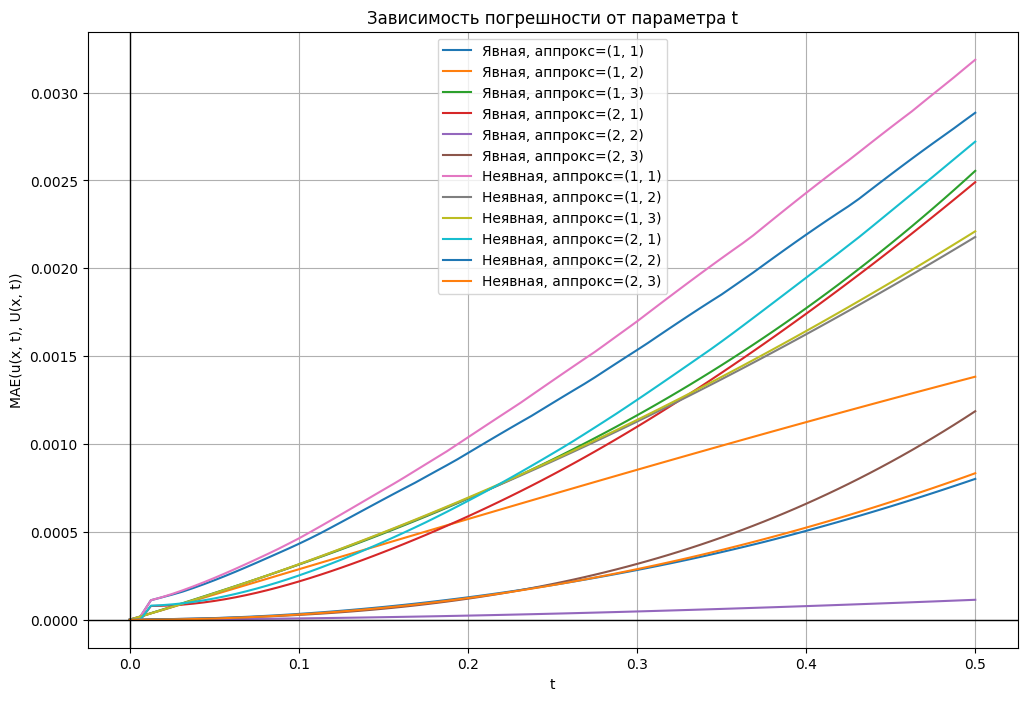

In [52]:
time = linspace(0, t, K + 1)
mae_u_explicit = [[0] * 3, [0] * 3]
mae_u_implicit = [[0] * 3, [0] * 3]
for i in range(2):
    for j in range(3):
        mae_u_explicit[i][j] = [0] * (K + 1)
        mae_u_implicit[i][j] = [0] * (K + 1)

for a in range(2):
    for b in range(3):
        for k in range(K + 1):
            for i in range(N + 1):
                mae_u_explicit[a][b][k] += abs(u_explicit[a][b][k][i] - analytic(tk(k, tau), xi(l, i, h)))
                mae_u_implicit[a][b][k] += abs(u_implicit[a][b][k][i] - analytic(tk(k, tau), xi(l, i, h)))
            mae_u_explicit[a][b][k] /= N
            mae_u_implicit[a][b][k] /= N
plt.figure(figsize=(12, 8))
for i in range(2):
    for j in range(3):
        plt.plot(time, mae_u_explicit[i][j], label=f"Явная, аппрокс={(i + 1, j + 1)}")

for i in range(2):
    for j in range(3):
        plt.plot(time, mae_u_implicit[i][j], label=f"Неявная, аппрокс={(i + 1, j + 1)}")
plt.xlabel('t')
plt.ylabel('MAE(u(x, t), U(x, t))')
plt.title('Зависимость погрешности от параметра t')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.legend()
plt.grid()
plt.show()

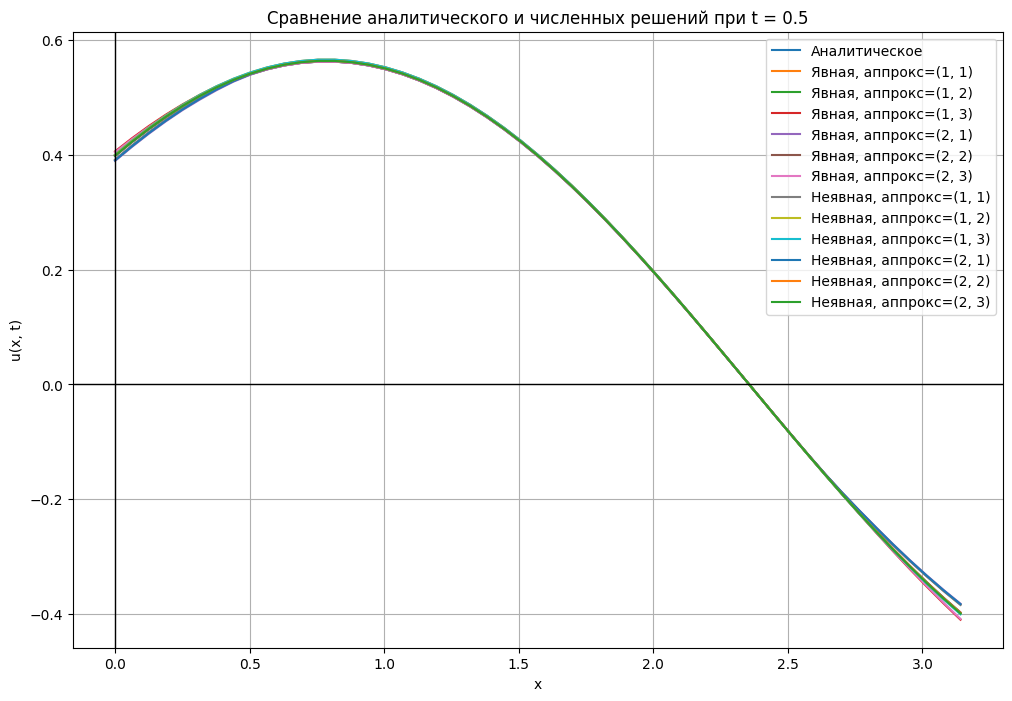

In [53]:
# time_index = int(input())
time_index = K
x = linspace(l, r, N + 1)
plt.figure(figsize=(12, 8))
current_time = tk(time_index, tau)
u_analytic_values = [analytic(current_time, xi(l, i, h)) for i in range(N + 1)]

plt.plot(x, u_analytic_values, label=f'Аналитическое')
for i in range(2):
    for j in range(3):
        plt.plot(x, [u_explicit[i][j][time_index][a] for a in range(N + 1)], label=f"Явная, аппрокс={(i + 1, j + 1)}")

for i in range(2):
    for j in range(3):
        plt.plot(x, [u_implicit[i][j][time_index][a] for a in range(N + 1)], label=f"Неявная, аппрокс={(i + 1, j + 1)}")

plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.title(f'Сравнение аналитического и численных решений при t = {current_time}')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.legend()
plt.grid()
plt.show()